# A04b: Applied Filtering

**Duration**: ~45 minutes

**Prerequisites**: 
- [A01: Signals and Sampling](A01_signals_and_sampling.ipynb)
- [A02: Frequency Domain](A02_frequency_domain.ipynb)
- [A04a: Filter Fundamentals](A04a_filter_fundamentals.ipynb)

## Learning Objectives

By the end of this notebook, you will be able to:

1. **Apply filters** to time-series signals using convolution and SciPy functions
2. **Understand edge effects** and transient artifacts from filtering
3. **Implement zero-phase filtering** using forward-backward filtering (filtfilt)
4. **Remove powerline noise** using notch filters and their harmonics
5. **Build a complete EEG preprocessing pipeline** with appropriate filtering stages
6. **Use MNE-Python** for filtering neurophysiological data

## Table of Contents

1. [Introduction](#section-1-introduction)
2. [Applying Filters to Signals](#section-2-applying-filters-to-signals)
3. [Edge Effects and Transients](#section-3-edge-effects-and-transients)
4. [Zero-Phase Filtering](#section-4-zero-phase-filtering)
5. [Notch Filtering for Powerline Noise](#section-5-notch-filtering-for-powerline-noise)
6. [Common EEG Filtering Pipeline](#section-6-common-eeg-filtering-pipeline)
7. [MNE-Python Integration](#section-7-mne-python-integration)
8. [Exercises](#section-8-exercises)
9. [Summary](#summary)
10. [External Resources](#external-resources)
11. [Discussion Questions](#discussion-questions)

---

In [1]:
# =============================================================================
# Imports
# =============================================================================

# Standard library
import sys
from pathlib import Path
from typing import Tuple, Optional

# Third-party
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from scipy.signal import filtfilt, lfilter, sosfilt, sosfiltfilt

# Local imports
src_path = Path.cwd().parents[2]
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from src.colors import COLORS

# Matplotlib configuration
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["font.size"] = 11

print(f"NumPy version: {np.__version__}")
print(f"Source path: {src_path}")

NumPy version: 2.3.5
Source path: /Users/remyramadour/Workspace/PPSP/Workshops/ConnectivityMetricsTutorials


## Section 1: Introduction

In the previous notebook (A04a), we learned how to **design** filters. Now we focus on **applying** them to actual signals.

Key challenges when applying filters:
- **Edge effects**: Filters need "warm-up" time, causing artifacts at signal boundaries
- **Phase distortion**: IIR filters shift different frequencies by different amounts
- **Powerline noise**: 50 Hz (Europe) or 60 Hz (US) interference is ubiquitous
- **Real-time vs offline**: Different constraints for different applications

For hyperscanning, **zero-phase filtering** is particularly important because we need to preserve the exact timing relationships between two participants' brain signals.

## Section 2: Applying Filters to Signals

Once we have filter coefficients, we need to apply them to our signal. The basic approach uses **convolution** (FIR) or **recursive filtering** (IIR).

Let's first create helper functions for filter design and application:

In [2]:
# =============================================================================
# Section 2: Filter Design Functions
# =============================================================================

from scipy.signal import butter, iirnotch, firwin


def design_iir_filter(
    cutoff: float | Tuple[float, float],
    fs: float,
    order: int = 4,
    btype: str = "low",
    ftype: str = "butter",
) -> Tuple[NDArray[np.floating], NDArray[np.floating]]:
    """
    Design an IIR filter.

    Parameters
    ----------
    cutoff : float or tuple of float
        Cutoff frequency in Hz. For bandpass/bandstop, provide (low, high).
    fs : float
        Sampling frequency in Hz.
    order : int, default=4
        Filter order.
    btype : str, default='low'
        Filter type: 'low', 'high', 'band', 'bandstop'.
    ftype : str, default='butter'
        IIR filter family: 'butter', 'cheby1', 'cheby2', 'ellip'.

    Returns
    -------
    b, a : ndarray
        Numerator and denominator coefficients.
    """
    nyq = fs / 2
    if isinstance(cutoff, (list, tuple)):
        Wn = [c / nyq for c in cutoff]
    else:
        Wn = cutoff / nyq

    if ftype == "butter":
        b, a = butter(order, Wn, btype=btype)
    else:
        from scipy.signal import iirfilter
        b, a = iirfilter(order, Wn, btype=btype, ftype=ftype)

    return b, a


def design_fir_filter(
    cutoff: float | Tuple[float, float],
    fs: float,
    numtaps: int = 101,
    btype: str = "low",
    window: str = "hamming",
) -> NDArray[np.floating]:
    """
    Design a FIR filter using the window method.

    Parameters
    ----------
    cutoff : float or tuple of float
        Cutoff frequency in Hz.
    fs : float
        Sampling frequency in Hz.
    numtaps : int, default=101
        Number of filter coefficients (should be odd).
    btype : str, default='low'
        Filter type: 'low', 'high', 'band', 'bandstop'.
    window : str, default='hamming'
        Window function.

    Returns
    -------
    h : ndarray
        FIR filter coefficients.
    """
    nyq = fs / 2
    if isinstance(cutoff, (list, tuple)):
        normalized_cutoff = [c / nyq for c in cutoff]
    else:
        normalized_cutoff = cutoff / nyq

    pass_zero = btype in ["low", "bandstop"]
    h = firwin(numtaps, normalized_cutoff, window=window, pass_zero=pass_zero)

    return h


print("✓ Filter design functions defined")

✓ Filter design functions defined


In [3]:
# =============================================================================
# Section 2: Apply Filter Function
# =============================================================================


def apply_filter(
    signal: NDArray[np.floating],
    b: NDArray[np.floating],
    a: NDArray[np.floating] | None = None,
    zero_phase: bool = True,
) -> NDArray[np.floating]:
    """
    Apply a filter to a signal.

    Parameters
    ----------
    signal : ndarray
        Input signal to filter.
    b : ndarray
        Numerator coefficients (or FIR coefficients).
    a : ndarray or None, default=None
        Denominator coefficients. If None, assumes FIR filter (a=[1]).
    zero_phase : bool, default=True
        If True, use zero-phase filtering (filtfilt).
        If False, use causal filtering (lfilter).

    Returns
    -------
    filtered : ndarray
        Filtered signal.
    """
    if a is None:
        a = np.array([1.0])

    if zero_phase:
        # Zero-phase filtering: forward-backward filtering
        filtered = filtfilt(b, a, signal)
    else:
        # Causal filtering: introduces phase delay
        filtered = lfilter(b, a, signal)

    return filtered


print("✓ apply_filter() function defined")

✓ apply_filter() function defined


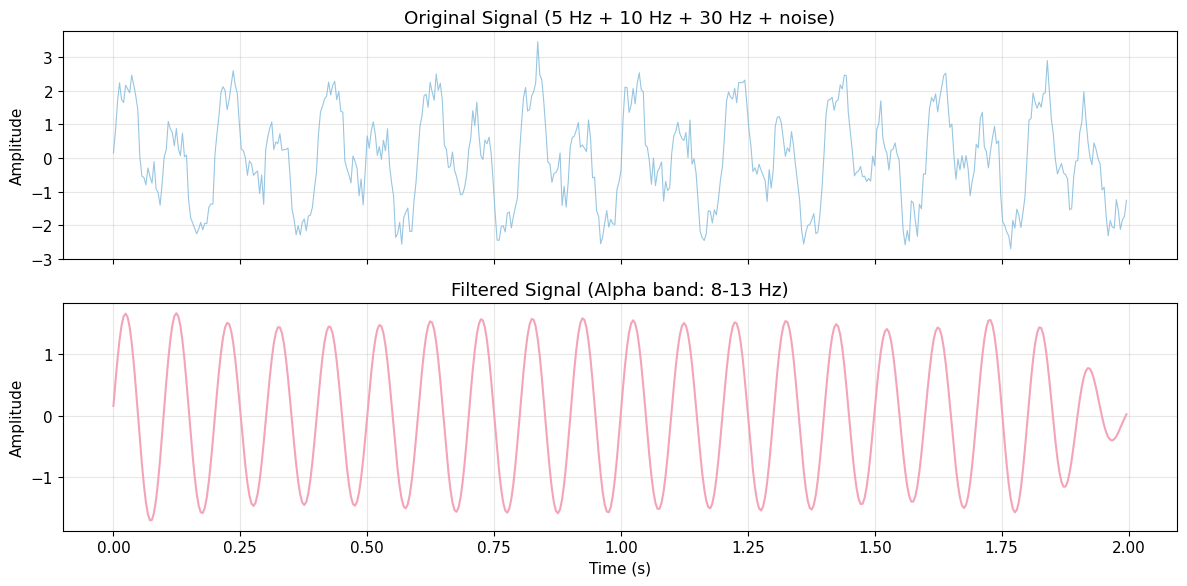

💡 The filter isolated the 10 Hz alpha component, removing theta, gamma, and noise.


In [4]:
# =============================================================================
# Section 2: Basic Filter Application Demo
# =============================================================================

# Create a test signal with multiple frequency components
fs = 250  # Hz
duration = 2  # seconds
t = np.arange(0, duration, 1/fs)

# Signal: 5 Hz (theta) + 10 Hz (alpha) + 30 Hz (gamma) + noise
np.random.seed(42)
signal = (
    1.0 * np.sin(2 * np.pi * 5 * t) +   # Theta
    1.5 * np.sin(2 * np.pi * 10 * t) +  # Alpha (strongest)
    0.5 * np.sin(2 * np.pi * 30 * t) +  # Gamma
    0.3 * np.random.randn(len(t))       # Noise
)

# Design and apply a bandpass filter for alpha (8-13 Hz)
b, a = design_iir_filter(cutoff=(8, 13), fs=fs, order=4, btype="band")
filtered = apply_filter(signal, b, a, zero_phase=True)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(t, signal, color=COLORS["signal_1"], linewidth=0.8, alpha=0.8)
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Original Signal (5 Hz + 10 Hz + 30 Hz + noise)")
axes[0].grid(True, alpha=0.3)

axes[1].plot(t, filtered, color=COLORS["signal_2"], linewidth=1.5)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Filtered Signal (Alpha band: 8-13 Hz)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 The filter isolated the 10 Hz alpha component, removing theta, gamma, and noise.")

## Section 3: Edge Effects and Transients

**Edge effects** (or filter transients) occur at the beginning and end of a filtered signal because the filter doesn't have enough past/future samples to work with.

These artifacts can be particularly problematic for:
- Short signals or epochs
- Event-related analyses where timing matters
- Connectivity measures at epoch boundaries

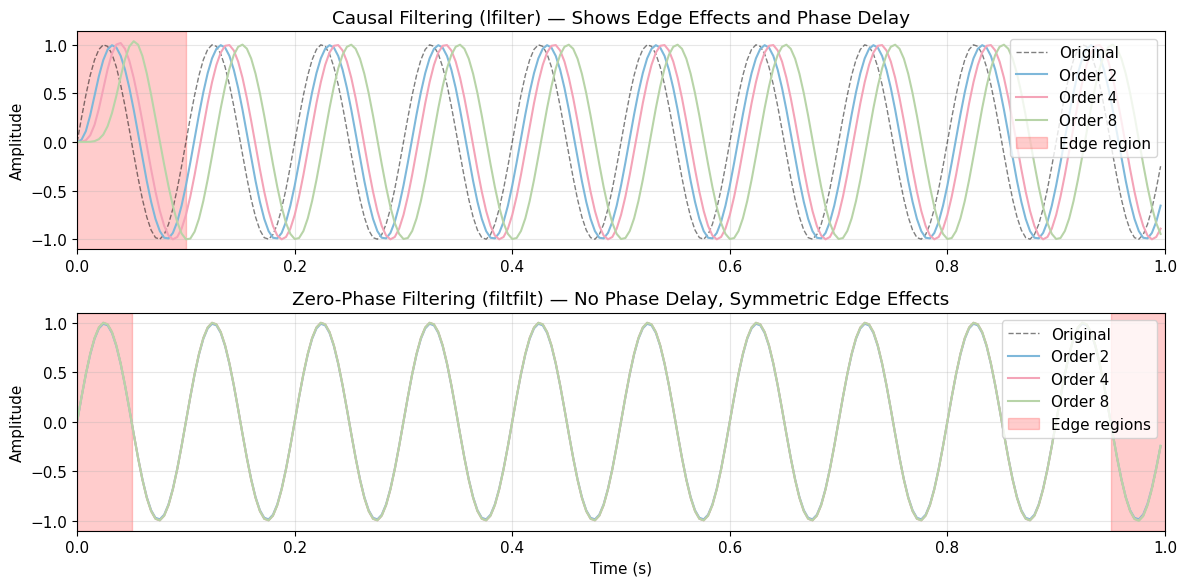

💡 Higher filter order = longer edge effects (more samples affected)
💡 Zero-phase filtering affects both start AND end of the signal


In [5]:
# =============================================================================
# Section 3: Demonstrating Edge Effects
# =============================================================================

# Create a short signal
fs = 250
duration = 1  # Short duration to show edge effects clearly
t = np.arange(0, duration, 1/fs)

# Pure 10 Hz sine wave
signal = np.sin(2 * np.pi * 10 * t)

# Apply lowpass filter with different orders
orders = [2, 4, 8]
colors = [COLORS["signal_1"], COLORS["signal_2"], COLORS["signal_3"]]

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Show causal filtering (lfilter) - has phase delay AND edge effects
axes[0].plot(t, signal, 'k--', linewidth=1, alpha=0.5, label="Original")
for order, color in zip(orders, colors):
    b, a = design_iir_filter(cutoff=30, fs=fs, order=order, btype="low")
    filtered_causal = lfilter(b, a, signal)
    axes[0].plot(t, filtered_causal, color=color, linewidth=1.5, label=f"Order {order}")

axes[0].axvspan(0, 0.1, alpha=0.2, color="red", label="Edge region")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Causal Filtering (lfilter) — Shows Edge Effects and Phase Delay")
axes[0].legend(loc="upper right")
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, duration)

# Show zero-phase filtering (filtfilt) - no phase delay but still has edge effects
axes[1].plot(t, signal, 'k--', linewidth=1, alpha=0.5, label="Original")
for order, color in zip(orders, colors):
    b, a = design_iir_filter(cutoff=30, fs=fs, order=order, btype="low")
    filtered_zerophase = filtfilt(b, a, signal)
    axes[1].plot(t, filtered_zerophase, color=color, linewidth=1.5, label=f"Order {order}")

axes[1].axvspan(0, 0.05, alpha=0.2, color="red")
axes[1].axvspan(duration-0.05, duration, alpha=0.2, color="red", label="Edge regions")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Zero-Phase Filtering (filtfilt) — No Phase Delay, Symmetric Edge Effects")
axes[1].legend(loc="upper right")
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, duration)

plt.tight_layout()
plt.show()

print("💡 Higher filter order = longer edge effects (more samples affected)")
print("💡 Zero-phase filtering affects both start AND end of the signal")

In [6]:
# =============================================================================
# Section 3: Strategies for Handling Edge Effects
# =============================================================================


def estimate_transient_samples(order: int, fs: float, cutoff: float) -> int:
    """
    Estimate the number of samples affected by filter transients.

    Parameters
    ----------
    order : int
        Filter order.
    fs : float
        Sampling frequency.
    cutoff : float
        Cutoff frequency (lowest for bandpass).

    Returns
    -------
    n_samples : int
        Estimated number of transient samples.
    """
    # Rule of thumb: ~3 cycles of the lowest frequency in the passband
    n_cycles = 3
    period = 1 / cutoff
    transient_time = n_cycles * period
    n_samples = int(np.ceil(transient_time * fs))

    # Also consider filter order (higher order = longer settling)
    n_samples = max(n_samples, order * 10)

    return n_samples


# Example
cutoff = 1  # Hz (highpass at 1 Hz has long transients)
order = 4
fs = 250

n_transient = estimate_transient_samples(order, fs, cutoff)
transient_time = n_transient / fs

print(f"Filter: Highpass {cutoff} Hz, order {order}")
print(f"Estimated transient: {n_transient} samples = {transient_time:.2f} seconds")
print(f"\n💡 Strategy: Pad signal before filtering, then trim the edges")

Filter: Highpass 1 Hz, order 4
Estimated transient: 750 samples = 3.00 seconds

💡 Strategy: Pad signal before filtering, then trim the edges


## Section 4: Zero-Phase Filtering

**Zero-phase filtering** (using `filtfilt`) applies the filter twice: once forward, once backward. This:
- Eliminates phase distortion (all frequencies are shifted by 0°)
- Doubles the effective filter order (sharper cutoff)
- Creates symmetric edge effects at both ends

For hyperscanning, zero-phase filtering is essential because we need to preserve the exact timing relationships between participants' brain signals.

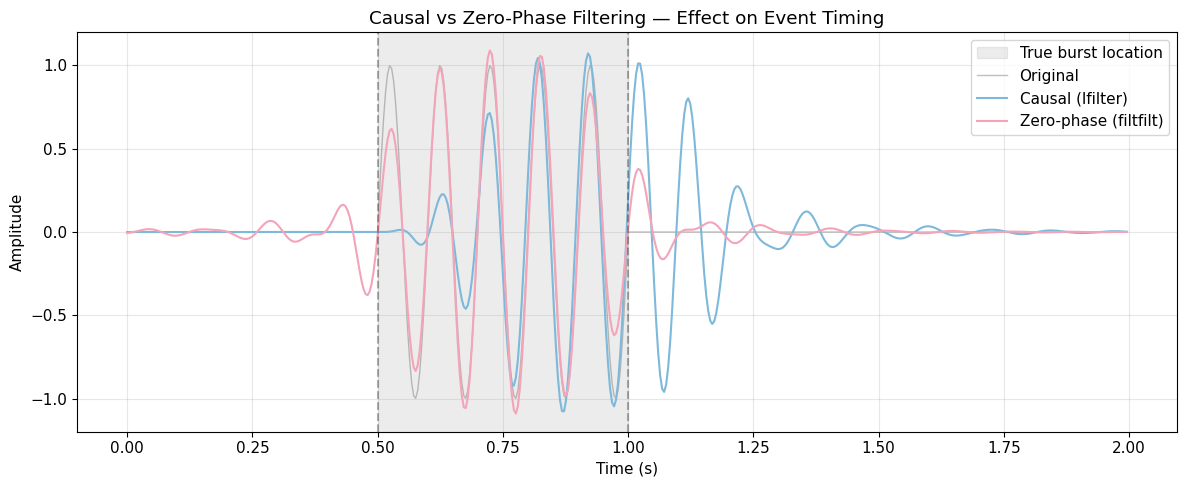

💡 Causal filtering DELAYS the signal — the filtered burst appears LATER
💡 Zero-phase filtering preserves timing — essential for connectivity analysis


In [7]:
# =============================================================================
# Section 4: Causal vs Zero-Phase Filtering
# =============================================================================

# Create a signal with a clear event (sudden change)
fs = 250
duration = 2
t = np.arange(0, duration, 1/fs)

# Signal with a "burst" of alpha activity
signal = np.zeros_like(t)
burst_start = 0.5
burst_end = 1.0
burst_mask = (t >= burst_start) & (t <= burst_end)
signal[burst_mask] = np.sin(2 * np.pi * 10 * t[burst_mask])  # 10 Hz burst

# Apply bandpass filter both ways
b, a = design_iir_filter(cutoff=(8, 13), fs=fs, order=4, btype="band")

filtered_causal = lfilter(b, a, signal)
filtered_zerophase = filtfilt(b, a, signal)

# Plot
fig, ax = plt.subplots(figsize=(12, 5))

ax.axvspan(burst_start, burst_end, alpha=0.15, color="gray", label="True burst location")
ax.plot(t, signal, color="gray", linewidth=1, alpha=0.5, label="Original")
ax.plot(t, filtered_causal, color=COLORS["signal_1"], linewidth=1.5, label="Causal (lfilter)")
ax.plot(t, filtered_zerophase, color=COLORS["signal_2"], linewidth=1.5, label="Zero-phase (filtfilt)")

ax.axvline(burst_start, color="black", linestyle="--", alpha=0.3)
ax.axvline(burst_end, color="black", linestyle="--", alpha=0.3)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Causal vs Zero-Phase Filtering — Effect on Event Timing")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Causal filtering DELAYS the signal — the filtered burst appears LATER")
print("💡 Zero-phase filtering preserves timing — essential for connectivity analysis")

## Section 5: Notch Filtering for Powerline Noise

**Powerline interference** at 50 Hz (Europe, Asia) or 60 Hz (Americas) is one of the most common artifacts in EEG. Notch filters remove this narrow-band noise while preserving other frequencies.

In [8]:
# =============================================================================
# Section 5: Notch Filter Functions
# =============================================================================


def notch_filter(
    signal: NDArray[np.floating],
    freq: float,
    fs: float,
    quality: float = 30.0,
    zero_phase: bool = True,
) -> NDArray[np.floating]:
    """
    Apply a notch filter to remove a specific frequency.

    Parameters
    ----------
    signal : ndarray
        Input signal.
    freq : float
        Frequency to remove (Hz).
    fs : float
        Sampling frequency.
    quality : float, default=30.0
        Quality factor. Higher = narrower notch.
    zero_phase : bool, default=True
        Use zero-phase filtering.

    Returns
    -------
    filtered : ndarray
        Signal with notch applied.
    """
    b, a = iirnotch(freq, quality, fs)

    if zero_phase:
        return filtfilt(b, a, signal)
    else:
        return lfilter(b, a, signal)


def notch_filter_harmonics(
    signal: NDArray[np.floating],
    base_freq: float,
    fs: float,
    n_harmonics: int = 3,
    quality: float = 30.0,
) -> NDArray[np.floating]:
    """
    Apply notch filters at a frequency and its harmonics.

    Parameters
    ----------
    signal : ndarray
        Input signal.
    base_freq : float
        Base frequency (e.g., 50 or 60 Hz).
    fs : float
        Sampling frequency.
    n_harmonics : int, default=3
        Number of harmonics to remove (including base).
    quality : float, default=30.0
        Quality factor for notch filters.

    Returns
    -------
    filtered : ndarray
        Signal with notches at base_freq, 2*base_freq, etc.
    """
    result = signal.copy()
    nyq = fs / 2

    for i in range(1, n_harmonics + 1):
        notch_freq = base_freq * i
        if notch_freq < nyq:  # Only if below Nyquist
            result = notch_filter(result, notch_freq, fs, quality)

    return result


print("✓ Notch filter functions defined")

✓ Notch filter functions defined


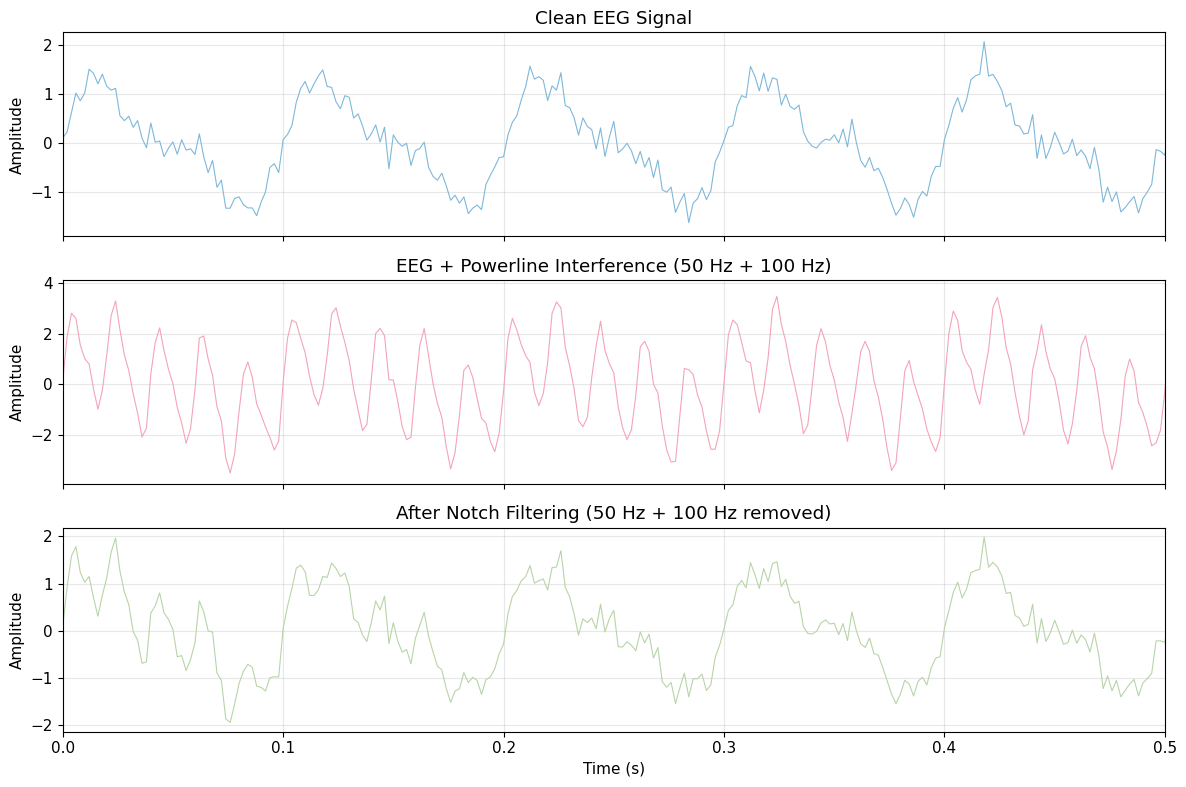

In [9]:
# =============================================================================
# Section 5: Notch Filtering Demo
# =============================================================================

# Create a signal with powerline interference
fs = 500  # Higher fs to capture 50 Hz properly
duration = 2
t = np.arange(0, duration, 1/fs)

# EEG-like signal with 50 Hz interference
np.random.seed(42)
eeg_clean = (
    1.0 * np.sin(2 * np.pi * 10 * t) +   # Alpha
    0.5 * np.sin(2 * np.pi * 20 * t) +   # Beta
    0.2 * np.random.randn(len(t))        # Neural noise
)

# Add powerline interference (50 Hz and its harmonic at 100 Hz)
powerline = (
    2.0 * np.sin(2 * np.pi * 50 * t) +    # 50 Hz
    0.5 * np.sin(2 * np.pi * 100 * t)     # 100 Hz harmonic
)
eeg_noisy = eeg_clean + powerline

# Apply notch filter
eeg_notched = notch_filter_harmonics(eeg_noisy, base_freq=50, fs=fs, n_harmonics=2)

# Plot time domain
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(t, eeg_clean, color=COLORS["signal_1"], linewidth=0.8)
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Clean EEG Signal")
axes[0].grid(True, alpha=0.3)

axes[1].plot(t, eeg_noisy, color=COLORS["signal_2"], linewidth=0.8)
axes[1].set_ylabel("Amplitude")
axes[1].set_title("EEG + Powerline Interference (50 Hz + 100 Hz)")
axes[1].grid(True, alpha=0.3)

axes[2].plot(t, eeg_notched, color=COLORS["signal_3"], linewidth=0.8)
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Amplitude")
axes[2].set_title("After Notch Filtering (50 Hz + 100 Hz removed)")
axes[2].grid(True, alpha=0.3)

plt.xlim(0, 0.5)  # Zoom to see detail
plt.tight_layout()
plt.show()

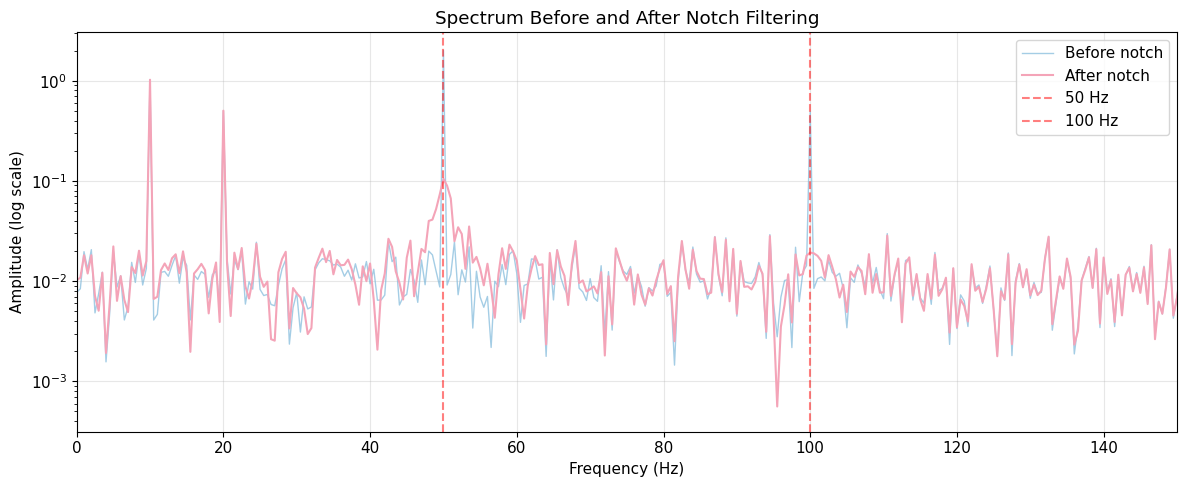

💡 The notch filter created 'notches' at 50 Hz and 100 Hz, removing the interference.


In [10]:
# =============================================================================
# Section 5: Frequency Domain View of Notch Filtering
# =============================================================================

from scipy.fft import fft, fftfreq

# Compute spectra
n = len(t)
freqs = fftfreq(n, 1/fs)[:n//2]

spectrum_noisy = np.abs(fft(eeg_noisy))[:n//2] * 2 / n
spectrum_notched = np.abs(fft(eeg_notched))[:n//2] * 2 / n

# Plot
fig, ax = plt.subplots(figsize=(12, 5))

ax.semilogy(freqs, spectrum_noisy, color=COLORS["signal_1"], linewidth=1, alpha=0.7, label="Before notch")
ax.semilogy(freqs, spectrum_notched, color=COLORS["signal_2"], linewidth=1.5, label="After notch")

ax.axvline(50, color="red", linestyle="--", alpha=0.5, label="50 Hz")
ax.axvline(100, color="red", linestyle="--", alpha=0.5, label="100 Hz")

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude (log scale)")
ax.set_title("Spectrum Before and After Notch Filtering")
ax.set_xlim(0, 150)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 The notch filter created 'notches' at 50 Hz and 100 Hz, removing the interference.")

## Section 6: Common EEG Filtering Pipeline

A typical EEG preprocessing pipeline includes multiple filtering steps in a specific order:

1. **Notch filter** (50/60 Hz) — Remove powerline interference
2. **Highpass filter** (0.1-1 Hz) — Remove slow drifts
3. **Lowpass filter** (40-100 Hz) — Remove high-frequency noise

Or combined as a single **bandpass filter** after the notch.

In [11]:
# =============================================================================
# Section 6: Complete Filtering Pipeline
# =============================================================================


def preprocess_eeg(
    signal: NDArray[np.floating],
    fs: float,
    highpass: float = 0.5,
    lowpass: float = 40.0,
    notch_freq: Optional[float] = 50.0,
    notch_harmonics: int = 2,
) -> NDArray[np.floating]:
    """
    Apply a standard EEG preprocessing pipeline.

    Parameters
    ----------
    signal : ndarray
        Raw EEG signal.
    fs : float
        Sampling frequency.
    highpass : float, default=0.5
        Highpass cutoff frequency.
    lowpass : float, default=40.0
        Lowpass cutoff frequency.
    notch_freq : float or None, default=50.0
        Powerline frequency (50 or 60 Hz). None to skip.
    notch_harmonics : int, default=2
        Number of harmonics to notch.

    Returns
    -------
    preprocessed : ndarray
        Preprocessed signal.
    """
    result = signal.copy()

    # Step 1: Notch filter (if requested)
    if notch_freq is not None:
        result = notch_filter_harmonics(
            result, notch_freq, fs, n_harmonics=notch_harmonics
        )

    # Step 2: Bandpass filter
    b, a = design_iir_filter(
        cutoff=(highpass, lowpass), fs=fs, order=4, btype="band"
    )
    result = filtfilt(b, a, result)

    return result


print("✓ preprocess_eeg() function defined")

✓ preprocess_eeg() function defined


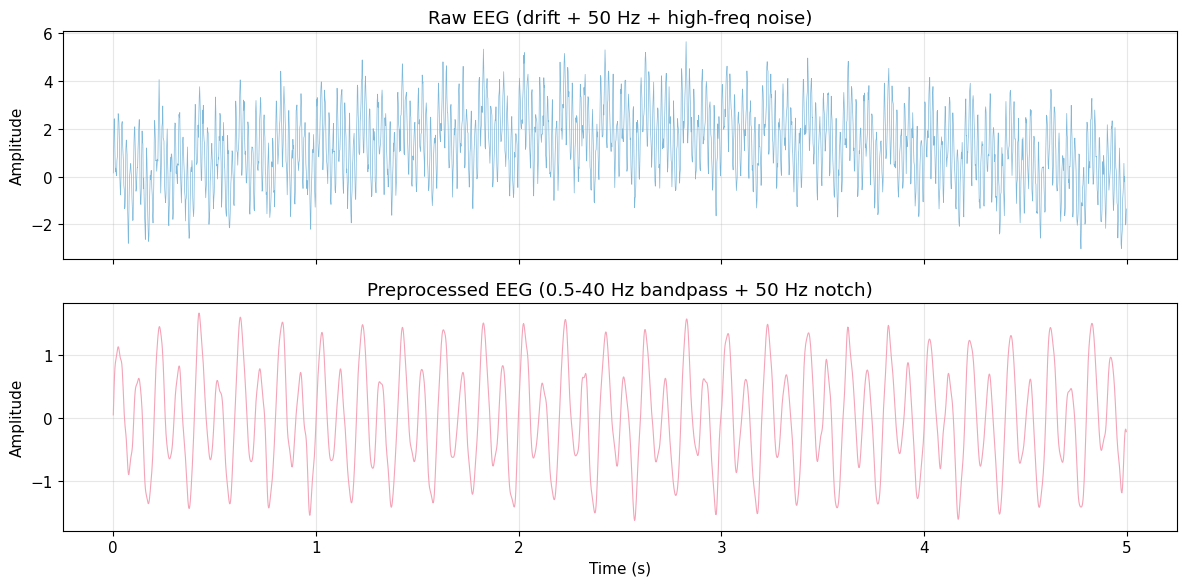

💡 The preprocessing removed slow drifts, powerline noise, and high-frequency artifacts.


In [12]:
# =============================================================================
# Section 6: Full Pipeline Demo
# =============================================================================

# Create a realistic noisy EEG signal
fs = 500
duration = 5
t = np.arange(0, duration, 1/fs)

np.random.seed(42)

# Neural activity (alpha + theta)
neural = (
    1.0 * np.sin(2 * np.pi * 10 * t) +  # Alpha
    0.5 * np.sin(2 * np.pi * 5 * t) +   # Theta
    0.3 * np.random.randn(len(t))       # Broadband neural noise
)

# Artifacts
slow_drift = 2.0 * np.sin(2 * np.pi * 0.1 * t)  # Slow drift (0.1 Hz)
powerline = 1.5 * np.sin(2 * np.pi * 50 * t)    # 50 Hz interference
high_freq = 0.5 * np.sin(2 * np.pi * 80 * t)    # High-freq noise

raw_eeg = neural + slow_drift + powerline + high_freq

# Apply preprocessing
clean_eeg = preprocess_eeg(raw_eeg, fs, highpass=0.5, lowpass=40, notch_freq=50)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(t, raw_eeg, color=COLORS["signal_1"], linewidth=0.5)
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Raw EEG (drift + 50 Hz + high-freq noise)")
axes[0].grid(True, alpha=0.3)

axes[1].plot(t, clean_eeg, color=COLORS["signal_2"], linewidth=0.8)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Preprocessed EEG (0.5-40 Hz bandpass + 50 Hz notch)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 The preprocessing removed slow drifts, powerline noise, and high-frequency artifacts.")

## Section 7: MNE-Python Integration

MNE-Python provides high-level filtering functions that handle many details automatically:
- Automatic filter design based on data properties
- Edge artifact handling
- Parallel processing for multi-channel data
- Proper handling of different data types (Raw, Epochs, etc.)

In [13]:
# =============================================================================
# Section 7: MNE-Style Filtering Function
# =============================================================================

from scipy.signal import firwin, filtfilt


def mne_filter_data(
    data: NDArray[np.floating],
    fs: float,
    l_freq: Optional[float] = None,
    h_freq: Optional[float] = None,
    method: str = "fir",
    fir_design: str = "firwin",
    filter_length: str = "auto",
) -> NDArray[np.floating]:
    """
    Filter data using MNE-style conventions.

    Parameters
    ----------
    data : ndarray
        Data to filter (samples,) or (channels, samples).
    fs : float
        Sampling frequency.
    l_freq : float or None
        Low cutoff frequency (highpass edge).
    h_freq : float or None
        High cutoff frequency (lowpass edge).
    method : str, default='fir'
        'fir' or 'iir'.
    fir_design : str, default='firwin'
        FIR design method.
    filter_length : str, default='auto'
        Filter length specification.

    Returns
    -------
    filtered : ndarray
        Filtered data.
    """
    # Determine filter type
    if l_freq is not None and h_freq is not None:
        btype = "band"
        cutoff = (l_freq, h_freq)
    elif l_freq is not None:
        btype = "high"
        cutoff = l_freq
    elif h_freq is not None:
        btype = "low"
        cutoff = h_freq
    else:
        return data  # No filtering needed

    # Auto filter length (MNE uses ~3.3 cycles of lowest frequency)
    if filter_length == "auto":
        if l_freq is not None:
            min_freq = l_freq
        else:
            min_freq = h_freq
        n_cycles = 3.3
        numtaps = int(n_cycles * fs / min_freq)
        numtaps = numtaps + 1 if numtaps % 2 == 0 else numtaps  # Ensure odd
        numtaps = max(numtaps, 51)  # Minimum length
        
        # Limit numtaps to avoid filtfilt padding issues
        # filtfilt needs padlen = 3 * numtaps by default
        n_samples = data.shape[-1] if data.ndim > 1 else len(data)
        max_numtaps = (n_samples - 1) // 3
        if max_numtaps % 2 == 0:
            max_numtaps -= 1  # Ensure odd
        numtaps = min(numtaps, max(max_numtaps, 51))
    else:
        numtaps = int(filter_length)

    if method == "fir":
        h = design_fir_filter(cutoff, fs, numtaps=numtaps, btype=btype)
        if data.ndim == 1:
            return filtfilt(h, [1.0], data)
        else:
            return np.array([filtfilt(h, [1.0], ch) for ch in data])
    else:
        b, a = design_iir_filter(cutoff, fs, order=4, btype=btype)
        if data.ndim == 1:
            return filtfilt(b, a, data)
        else:
            return np.array([filtfilt(b, a, ch) for ch in data])


print("✓ mne_filter_data() function defined")
print("\n💡 This mimics MNE-Python's filter_data() function conventions.")


✓ mne_filter_data() function defined

💡 This mimics MNE-Python's filter_data() function conventions.


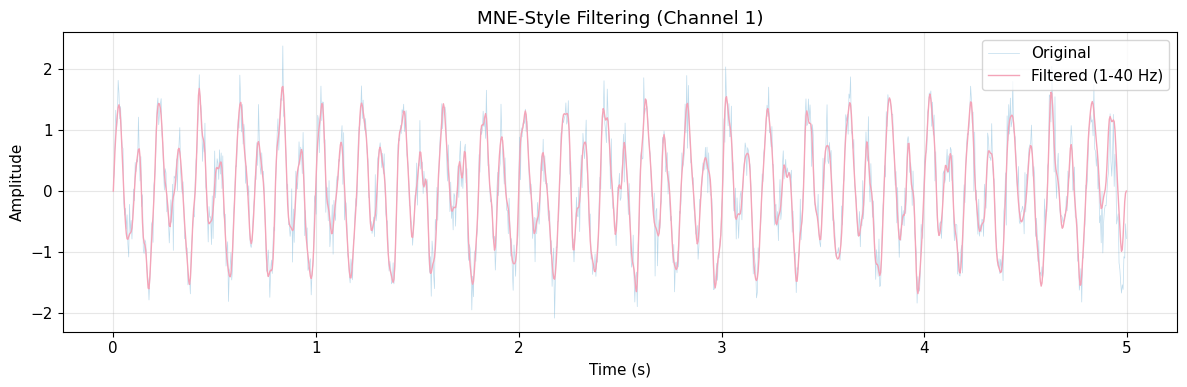

📊 Input shape: (4, 1250)
📊 Output shape: (4, 1250)


In [14]:
# =============================================================================
# Section 7: MNE-Style Filtering Demo
# =============================================================================

# Create multi-channel data (simulating EEG with 4 channels)
fs = 250
duration = 5
n_channels = 4
t = np.arange(0, duration, 1/fs)

np.random.seed(42)

# Generate 4 channels with similar content but different noise
data = np.zeros((n_channels, len(t)))
for i in range(n_channels):
    data[i] = (
        1.0 * np.sin(2 * np.pi * 10 * t + i * np.pi/4) +  # Alpha with phase shift
        0.5 * np.sin(2 * np.pi * 5 * t) +                  # Theta
        0.3 * np.random.randn(len(t))                      # Noise
    )

# Filter using MNE-style function
data_filtered = mne_filter_data(data, fs, l_freq=1, h_freq=40)

# Plot one channel before/after
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(t, data[0], color=COLORS["signal_1"], linewidth=0.5, alpha=0.5, label="Original")
ax.plot(t, data_filtered[0], color=COLORS["signal_2"], linewidth=1, label="Filtered (1-40 Hz)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("MNE-Style Filtering (Channel 1)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Input shape: {data.shape}")
print(f"📊 Output shape: {data_filtered.shape}")

---

<a id="section-8-exercises"></a>
## 8. Exercises

### 🎯 Exercise 1: Compare Edge Effects

**Task:** Create a 1-second signal and compare edge effects with different filter orders.

- Create a pure 10 Hz sine wave (1 second, fs=250 Hz)
- Apply lowpass filters with orders 2, 4, and 8
- Measure how many samples deviate from the original at each end

```python
# Your code here
fs = 250
t = np.arange(0, 1, 1/fs)
signal = np.sin(2 * np.pi * 10 * t)

# Apply filters with different orders and compare edge effects
# ...
```

<details>
<summary>💡 Click to reveal solution</summary>

```python
fs = 250
t = np.arange(0, 1, 1/fs)
signal = np.sin(2 * np.pi * 10 * t)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(t, signal, 'k--', linewidth=1, alpha=0.5, label="Original")

for order, color in zip([2, 4, 8], [COLORS["signal_1"], COLORS["signal_2"], COLORS["signal_3"]]):
    b, a = design_iir_filter(cutoff=30, fs=fs, order=order, btype='low')
    filtered = filtfilt(b, a, signal)
    
    # Calculate error
    error = np.abs(filtered - signal)
    n_affected = np.sum(error > 0.01)  # Threshold for "affected"
    
    ax.plot(t, filtered, color=color, linewidth=1.5, label=f"Order {order} ({n_affected} samples affected)")

ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Edge Effects vs Filter Order")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
```

</details>


### 🎯 Exercise 2: Build a Custom Theta Pipeline

**Task:** Create a function that extracts theta activity while removing powerline noise.

- Apply notch filter at 60 Hz (US powerline)
- Apply bandpass filter for theta band (4-8 Hz)
- Test on a synthetic signal with theta + 60 Hz noise + random noise

```python
# Your code here
def extract_theta(signal, fs):
    """Extract theta band activity with powerline removal."""
    # Step 1: Notch at 60 Hz
    # ...
    # Step 2: Bandpass 4-8 Hz
    # ...
    pass
```

<details>
<summary>💡 Click to reveal solution</summary>

```python
def extract_theta(signal, fs):
    """Extract theta band activity with powerline removal."""
    # Step 1: Notch at 60 Hz
    result = notch_filter(signal, freq=60, fs=fs, quality=30)
    
    # Step 2: Bandpass 4-8 Hz
    b, a = design_iir_filter(cutoff=(4, 8), fs=fs, order=4, btype='band')
    result = filtfilt(b, a, result)
    
    return result

# Test
fs = 500
duration = 3
t = np.arange(0, duration, 1/fs)

# Create test signal
np.random.seed(42)
theta = np.sin(2 * np.pi * 6 * t)  # 6 Hz theta
powerline = 0.5 * np.sin(2 * np.pi * 60 * t)  # 60 Hz noise
noise = 0.2 * np.random.randn(len(t))
test_signal = theta + powerline + noise

# Apply pipeline
extracted = extract_theta(test_signal, fs)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(t, test_signal, color=COLORS["signal_1"], linewidth=0.5)
axes[0].set_title("Original (theta + 60 Hz + noise)")
axes[0].set_ylabel("Amplitude")
axes[0].grid(True, alpha=0.3)

axes[1].plot(t, extracted, color=COLORS["signal_2"], linewidth=1)
axes[1].set_title("Extracted Theta (4-8 Hz)")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
```

</details>


## Summary

Key takeaways from this notebook:

- **Filter application**: Use `filtfilt()` for zero-phase filtering, `lfilter()` for causal filtering
- **Edge effects**: Filters need warm-up time; plan for transients at signal boundaries
- **Zero-phase filtering**: Essential for connectivity analysis to preserve timing
- **Notch filters**: Remove powerline interference (50/60 Hz and harmonics)
- **Standard pipeline**: Notch → Highpass → Lowpass (or combined bandpass)

### Functions Defined

| Function | Purpose |
|----------|----------|
| `apply_filter()` | Apply filter with optional zero-phase |
| `notch_filter()` | Remove single frequency |
| `notch_filter_harmonics()` | Remove frequency and its harmonics |
| `preprocess_eeg()` | Complete EEG preprocessing pipeline |
| `mne_filter_data()` | MNE-style filtering function |

### For Hyperscanning

When filtering signals from two participants:
- Always use zero-phase filtering to preserve timing
- Apply identical filter parameters to both participants
- Be aware of edge effects when epoching around events

## External Resources

### 🎧 NotebookLM Resources

- [📺 Video Overview](https://notebooklm.google.com/notebook/5d899740-f497-4339-ac73-909dbf71c3af?artifactId=0af231ba-8877-4cad-b821-f4f25085f345) - Video overview of applied filtering concepts
- [📝 Quiz](https://notebooklm.google.com/notebook/5d899740-f497-4339-ac73-909dbf71c3af?artifactId=bdc62b32-eb64-4961-b1c5-89c1743e3f3b) - Test your understanding
- [🗂️ Flashcards](https://notebooklm.google.com/notebook/5d899740-f497-4339-ac73-909dbf71c3af?artifactId=1ebd1709-713c-49c3-8feb-e077e09c0c57) - Review key concepts

### Documentation
- [SciPy filtfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html) - Zero-phase filtering
- [MNE-Python filter tutorial](https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html) - Comprehensive filtering guide

### Scientific Papers
- [Widmann et al. (2015)](https://doi.org/10.1016/j.jneumeth.2014.08.002) - Digital filter design for electrophysiological data
- [de Cheveigné & Nelken (2019)](https://doi.org/10.1016/j.neuron.2019.02.039) - Filters: When, Why, and How to Use Them

### Tutorials
- [FieldTrip filtering FAQ](https://www.fieldtriptoolbox.org/faq/what_kind_of_filters_can_i_apply_to_my_data/) - Practical filtering advice


## Discussion Questions

1. **Real-time applications**: In a real-time hyperscanning setup, you can't use `filtfilt()`. What alternatives exist for minimizing phase distortion?

2. **Edge effects in epochs**: If you're epoching around events (-500 to +1000 ms), how would you handle filter edge effects?

3. **Filter order trade-offs**: Why might you choose a lower filter order even though higher orders give sharper cutoffs?

4. **Notch vs bandpass**: When removing 50 Hz noise, why use a notch filter instead of just setting lowpass to 49 Hz?

5. **Hyperscanning considerations**: If participant A's signal has more noise than participant B's, should you use different filter settings?